### Advanced task: image captioning with visual attention

![img](https://i.imgur.com/r3r0fS4.jpg)

__This task__ walks you through all steps required to build an attentive image-to-captioning system. Except this time, there's no `<YOUR CODE HERE>`'s. You write all the code.

You are free to approach this task in any way you want. Follow our step-by-step guide or abandon it altogether. Use the notebook or add extra .py files (remember to add them to your anytask submission). The only limitation is that your code should be readable and runnable top-to-bottom.



### Step 1: image preprocessing (5 pts)

First, you need to prepare images for captioning. Just like in the basic notebook, you are going to use a pre-trained image classifier from the model zoo. Let's go to the [`preprocess_data.ipynb`](./preprocess_data) notebook and change a few things there. This stage is mostly running the existing code with minor modiffications.

1. Download the data someplace where you have enough space. You will need around 100Gb for the whole thing.
2. Pre-compute and save Inception activations at the layer directly __before the average pooling__.
 - the correct shape should be `[batch_size, 2048, 8, 8]`. Your LSTM will attend to that 8x8 grid.


__Note 1:__ Inception is great, but not the best model in the field. If you have enough courage, consider using ResNet or DenseNet from the same model zoo. Just remember that different models may require different image preprocessing.

__Note 2:__ Running this model on CPU may take days. You can speed things up by processing data in parts using colab + google drive. Here's how you do that: https://colab.research.google.com/notebooks/io.ipynb

In [1]:
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


In [2]:
import json
import torch

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from collections import Counter
from itertools import chain
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
from tqdm import tqdm_notebook, trange
from scipy.misc import imresize
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from random import choice
from beheaded_inception3 import beheaded_inception_v3

%matplotlib inline

torch.cuda.device_count()

1

In [3]:
DEVICE = torch.device('cuda:0')

In [4]:
%%time

inception_repr = np.load("../hw4/data/image_codes_for_attn.npy")
captions = json.load(open('../hw4/data/captions_tokenized.json'))

CPU times: user 148 ms, sys: 35.5 s, total: 35.6 s
Wall time: 35.6 s


### Step 2: sub-word tokenization (5 pts)

While it is not strictly necessary for image captioning, you can generally improve generative text models by using sub-word units. There are several sub-word tokenizers available in the open-source (BPE, Wordpiece, etc).

* __[recommended]__ BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory on how it works: https://arxiv.org/abs/1508.07909
* We recommend starting with __4000 bpe rules__.
* The result@@ ing lines will contain splits for rare and mis@@ typed words like this: ser@@ endi@@ pity


In [5]:
with open('captions.txt', 'w') as out:
    for img_idx in range(len(captions)):
        for caption_idx in range(len(captions[img_idx])):
            out.write(captions[img_idx][caption_idx] + '\n')

learn_bpe(open('./captions.txt'), open('./bpe_rules.txt', 'w'), num_symbols=4000)

In [6]:
bpe = BPE(open('./bpe_rules.txt'))

In [7]:
for img_idx in tqdm_notebook(range(len(captions))):
    for caption_idx in range(len(captions[img_idx])):
        captions[img_idx][caption_idx] = ['__BOS__'] + \
            bpe.process_line(captions[img_idx][caption_idx]).split() + ['__EOS__']
        
captions = np.array(captions)

In [8]:
word_counts = Counter(token for img_caption in captions for caption in img_caption for token in caption)

In [9]:
vocab = [word for word, count in word_counts.items() if count >= 10]
vocab += ['__UNK__', '__PAD__']

n_tokens = len(vocab)
word2idx = {word: idx for idx, word in enumerate(vocab)}

EOS = word2idx['__EOS__']
UNK = word2idx['__UNK__']
PAD = word2idx['__PAD__']
BOS = word2idx['__BOS__']

In [10]:
def as_matrix(sequences, max_len=None):
    max_len = max_len or max(map(len,sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32') + PAD
    for i, seq in enumerate(sequences):
        row_ix = [word2idx.get(word, UNK) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [11]:
train_imgs, val_imgs, train_captions, val_captions = train_test_split(
    inception_repr, captions, test_size=0.1, random_state=7)

### Step 3: define attentive decoder (5 pts)

Your model works similarly to the normal image captioning decoder, except that it has an additional mechanism for peeping into image at each step. We recommend implementing this mechanism as a separate Attention layer, inheriting from `nn.Module`. Here's what it should do:

![img](https://camo.githubusercontent.com/1f5d1b5def5ab2933b3746c9ef51f4622ce78b86/68747470733a2f2f692e696d6775722e636f6d2f36664b486c48622e706e67)


__Input:__ 8x8=64 image encoder vectors $ h^e_0, h^e_1, h^e_2, ..., h^e_64$ and a single decoder LSTM hidden state $h^d$.

* Compute logits with a 2-layer neural network with tanh activation (or anything similar)

$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$

* Get probabilities from logits, 

$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

You can now feed this $attn$ to the decoder LSTM in concatenation with previous token embeddings.

__Note 1:__ If you need more information on how attention works, here's [a class in attentive seq2seq](https://github.com/yandexdataschool/nlp_course/tree/master/week04_seq2seq) from the NLP course.

__Note 2:__ There's always a choice whether you initialize LSTM state with some image features or zeros. We recommend using zeros: it is a good way to debug whether your attention is working and it usually produces better-looking attention maps

In [12]:
class AttentionLayer(torch.nn.Module):
    def __init__(self, state_size, img_shape, hid_size=256):
        super(self.__class__, self).__init__()
        
        self.img_shape = img_shape
        
        self.dense_e = nn.Linear(img_shape[0], hid_size)
        self.dense_d = nn.Linear(state_size, hid_size)
        self.logits = nn.Linear(hid_size, 1)
        
    def forward(self, states, img_reprs):
        img_reprs = img_reprs.permute(0, 2, 3, 1) # outline channels
        
        dense_e = self.dense_e(img_reprs) # apply dense layer to channels
        dense_d = self.dense_d(states)[:, None, None, :] # apply dense layer to decoder state
        
        activated = torch.tanh(dense_e + dense_d)
        logits = self.logits(activated)[:, :, :, 0]
        
        mask = torch.softmax(logits.view(logits.shape[0], -1), dim=-1).reshape(logits.shape)[:, :, :, None]
        masked = img_reprs * mask
        self.mask_ = mask
        
        return torch.sum(masked, dim=(1, 2)) # [batch_size, n_channels]

In [13]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_out_shape=[2048, 8, 8]):
        super(self.__class__, self).__init__()
        
        self.n_tokens = n_tokens
        self.emb_size = emb_size
        self.lstm_units = lstm_units
        linear_attn_out_size = 2 * emb_size
        
        self.attn = AttentionLayer(lstm_units, cnn_out_shape)
        self.attn_enc = nn.Linear(cnn_out_shape[0], linear_attn_out_size)
        #self.repr2h0 = nn.Linear(cnn_out_shape[0], lstm_units)
        #self.repr2c0 = nn.Linear(cnn_out_shape[0], lstm_units)

        #self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.emb = nn.Embedding(n_tokens, emb_size)
        self.lstm_cell = nn.LSTMCell(emb_size + linear_attn_out_size, lstm_units)
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, inception_repr, captions_ix):
        #pooled = self.avg_pool(inception_repr)[:, :, 0, 0]
        
        #prev_c = self.repr2c0(pooled)
        #prev_h = self.repr2h0(pooled)
        
        # Here we guarantee that all information will flow through attention layer only
        prev_c = torch.zeros(captions_ix.shape[0], self.lstm_units, device=DEVICE)
        prev_h = torch.zeros(captions_ix.shape[0], self.lstm_units, device=DEVICE)

        embs = self.emb(captions_ix)
        lstm_out = torch.empty(*captions_ix.shape[:2][::-1], self.lstm_units, device=DEVICE)
        
        for i, emb in enumerate(embs.permute(1, 0, 2)): # [caption_length, batch, emb_size]
            attn = self.attn(prev_h, inception_repr)
            attn = self.attn_enc(attn)
            concated = torch.cat([emb, attn], dim=1)
            prev_h, prev_c = self.lstm_cell(concated, (prev_h, prev_c))
            lstm_out[i] = prev_h
            
        logits = self.logits(lstm_out.permute(1, 0, 2))
        
        return logits

In [14]:
model = CaptionNet(n_tokens)
if DEVICE.type == 'cuda':
    model.cuda()

### Step 4: training

Up to 10 pts based on the model performance. 
The training procedure for your model is no different from the original non-attentive captioning from the base track: iterate minibatches, compute loss, backprop, use the optimizer.

Feel free to use the [`basic track notebook`](./homework04_basic_part2_image_captioning) for "inspiration" :)


In [15]:
def compute_loss(model, image_vectors, captions_ix):
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    logits_for_next = model.forward(image_vectors, captions_ix_inp)
    loss = F.cross_entropy(logits_for_next.view(-1, logits_for_next.shape[-1]),
                           captions_ix_next.view(-1))
    
    return loss.mean().reshape(1)

In [16]:
def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice, captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32, device=DEVICE), \
           torch.tensor(batch_captions_ix, dtype=torch.int64, device=DEVICE)

In [17]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=10e-6)

In [18]:
batch_size = 100
n_epochs = 200
n_batches_per_epoch = 100
n_validation_batches = 10

train_log = []
val_log = []

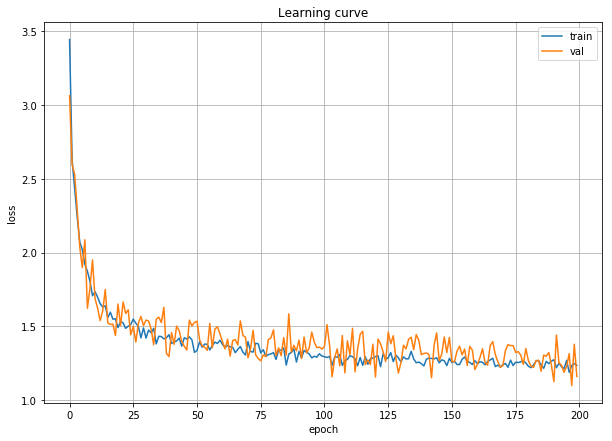

100%|██████████| 200/200 [1:01:19<00:00, 18.40s/it]


In [19]:
for epoch in trange(n_epochs):
    train_loss = 0
    model.train(True)
    for _ in range(n_batches_per_epoch):
        loss = compute_loss(model, *generate_batch(train_imgs, train_captions, batch_size))
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.item()
        
    train_loss /= n_batches_per_epoch
    train_log.append(train_loss)
    
    val_loss = 0
    model.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(model, *generate_batch(val_imgs, val_captions, batch_size))
        val_loss += loss_t.item()
        
    val_loss /= n_validation_batches
    val_log.append(val_loss)
    
    clear_output(True)
    plt.figure(figsize=(10, 7))
    plt.plot(range(len(train_log)), train_log, label='train')
    plt.plot(range(len(val_log)), val_log, label='val')
    plt.title('Learning curve')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

### Final step: show us what it's capable of! (5 pts)

The task is exactly the same as in the base track _(with the exception that you don't have to deal with salary prediction :) )_


__Task: Find at least 10 images to test it on.__

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

In [29]:
inception = beheaded_inception_v3().train(False).cuda()

def generate_caption(model, image, caption_prefix=('__BOS__',), 
                     t=1, sample=True, max_len=100, show_attn=False):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >= 0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32, device=DEVICE)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64, device=DEVICE)
            next_word_logits = model.forward(vectors_8x8, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).cpu().data.numpy()

            assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature
                
            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]
                
                
            if show_attn:
                mask = model.attn.mask_[0, :, :, 0]
                plt.imshow(mask / mask.max())
                print(next_word)
                plt.show()

            caption_prefix.append(next_word)

            if next_word == '__EOS__':
                break
            
    return caption_prefix

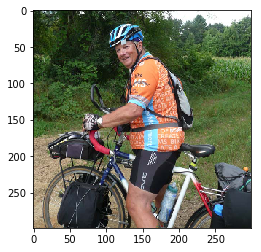

a man standing next to a bike with a bike .
a man and a woman on a bike with a bike .
a man is on a bike with a bike in his mouth
a man in a black shirt and a helmet on a bike .
a man is holding a bike in his hand .
a man in a black jacket and a hat on a bike .
a man in a hat and helmet on a bike .


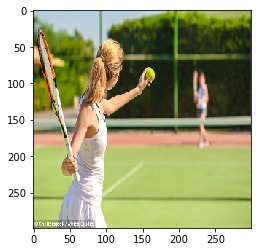

a man in a white shirt playing tennis
a man in a white shirt and a white shirt and a white shirt and a white shirt and a tennis racket
a tennis player is holding a racket in the air .
a man is swinging a tennis racket in a tennis court .
a man in a white shirt and a white shirt and a tennis racket
a man holding a tennis racquet on a tennis court .
a woman in a white shirt playing tennis


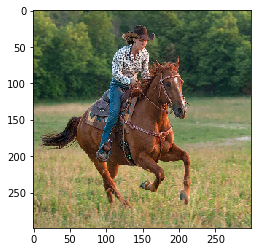

a woman in a brown jacket riding a horse
a woman riding a horse in a field .
a woman in a brown jacket riding a brown horse
a woman in a cowboy hat riding a horse .
a woman riding a horse on a field .
a woman riding a horse in the middle of a field .
a woman riding a brown horse in a field .


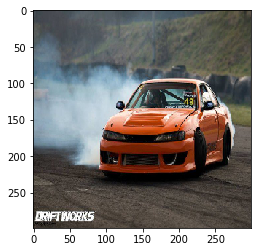

a red car parked in the grass next to a yellow car .
a car parked next to a yellow fire hydrant .
a red car parked next to a car .
a yellow car parked on the side of a road .
a car parked on the side of a road .
a red car parked in a parking lot .
a red and white car parked on the side of a road .


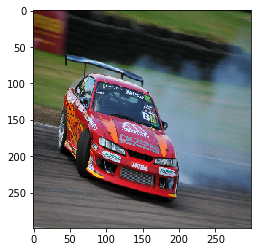

a red and white car parked in a parking lot .
a car parked on the side of a road .
a car parked in a parking lot with a car parked in the back .
a car parked in the middle of a road .
a car parked on the side of a road .
a car parked on the side of a road .
a car parked on the side of a road .


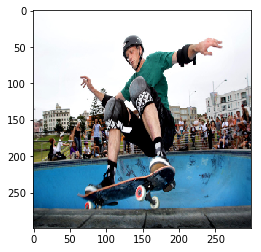

a man on a skateboard is doing a trick .
a man is riding a skateboard in a skate park .
a man on a skateboard in the air .
a man on a skateboard is doing a trick .
a man in a blue shirt on a skateboard .
a man on a skateboard doing a trick on a ramp .
a man in a black shirt is doing a trick


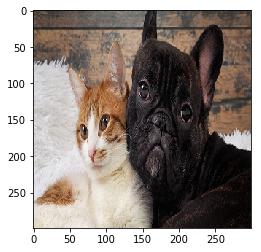

a cat sitting on top of a chair looking at the camera .
a cat is sitting on a chair with a remote .
a cat laying on top of a couch with a white cat .
a cat is sitting on a chair with a cat .
a cat sitting on a chair next to a black and white dog .
a cat sits on a chair looking at a camera .
a cat sitting in front of a door with a cat in the background .


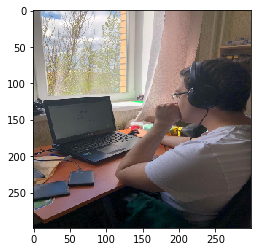

a woman sitting in a chair with a laptop .
a woman sitting on a laptop while sitting on a desk .
a woman sitting in front of a laptop computer .
a woman sitting in front of a laptop computer .
a woman sitting on a laptop computer on a table .
a woman sitting on a wooden table with a laptop .
a woman sitting on a desk with a laptop .


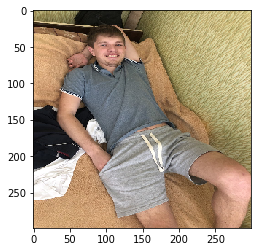

a man in a blue shirt and a white shirt and a black and white cat
a man sitting on a couch with a remote control .
a man is sitting on a couch with a remote .
a man is sitting on a couch with a cat .
a man in a white shirt and a white shirt and a white shirt
a woman sitting on a couch with a remote .
a man in a white shirt and a white shirt and a white shirt and a white couch


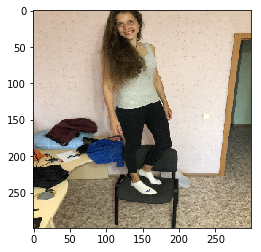

a woman with a cat on her lap and a cat .
a woman standing in a bed with a cat .
a woman is playing with her toy on the bed .
a woman and her young girl sitting on a couch .
a woman in a pink shirt and a black cat laying on a bed .
a woman is playing a video game with a woman
a girl is playing with a toy in a room .


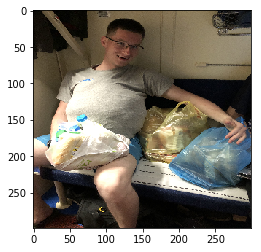

a man sitting in a chair with a blanket and a baby .
a man sitting in a chair holding a box of food .
a woman sitting in a chair with a stuffed animal .
a man in a suit and a hat at a table with a cake
a woman sitting in a chair with a baby .
a man sitting in a chair with a stuffed animal .
a man in a red shirt and a hat in a box


In [86]:
from PIL import Image

imgs_pathes = [
    '../hw4/data/bike.jpg',
    '../hw4/data/womantennis.jpg',
    '../hw4/data/womanhorse.jpg',
    '../hw4/data/drift1.jpg',
    '../hw4/data/drift2.jpg',
    '../hw4/data/skateboard.jpg',
    '../hw4/data/catdog.jpg',
    '2019-05-03 13.37.29.jpg',
    '2019-05-03 13.56.45.jpg',
    'IMG_3403.JPG',
    'IMG_3452.JPG',
]

imgs = []

for img_path in imgs_pathes:
    img = Image.open(img_path)
    img = np.array(img.resize((299, 299)), dtype='float32') / 255.
    imgs.append(img)
    
imgs = np.array(imgs)
imgs[9:11] = imgs[9:11].swapaxes(1, 2)
for img in imgs:
    plt.imshow(img)
    plt.show()
    for _ in range(7):
        caption = ' '.join(generate_caption(model, img, t=3., caption_prefix=['__BOS__'])[1:-1])
        print(caption.replace('@@ ', ''))

The guesses about food in the pre-last one was pretty close and unexpected. Let's look at some attention maps.

/cephfs/home/tushin/kirill/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


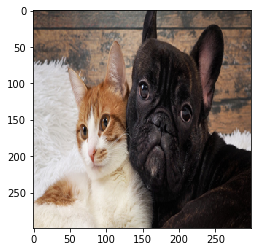

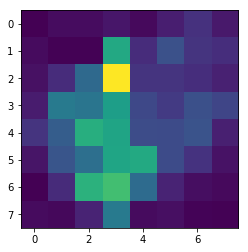

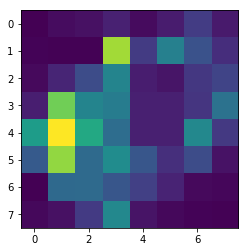

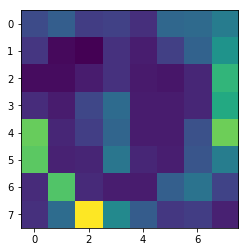

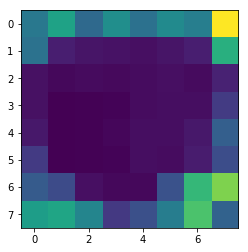

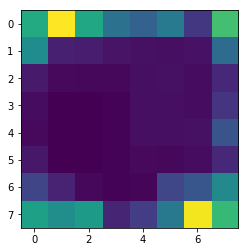

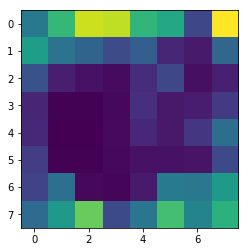

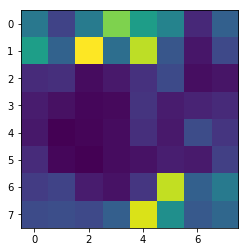

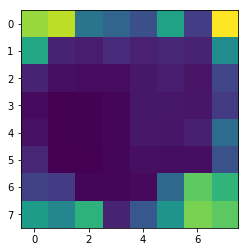

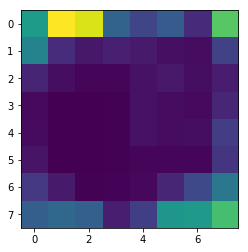

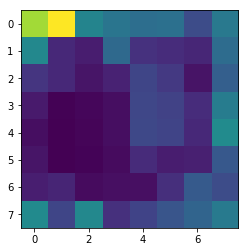

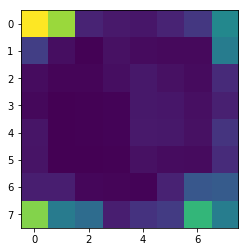

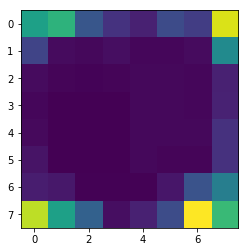

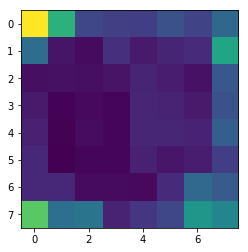

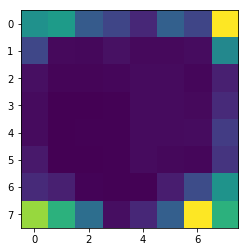

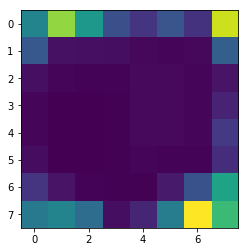

a cat is sitting on a chair with a red and white cat .


In [26]:
img = plt.imread('../hw4/data/catdog.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.
plt.imshow(img)
plt.show()
print(' '.join(generate_caption(model, img, t=5., show_attn=True)[1:-1]))

In this messed up example we can see that attention focuses on the cat only and then draws to background or whatever and completely misses the dog, which results in generating text about cats only.

/cephfs/home/tushin/kirill/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


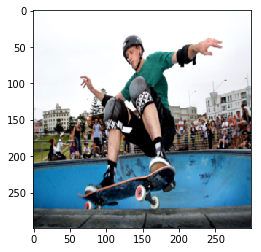

a


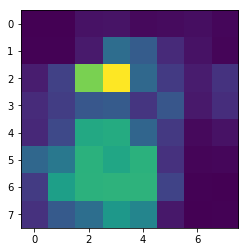

man


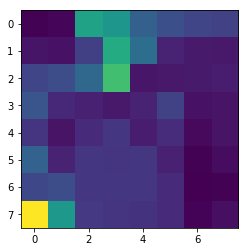

riding


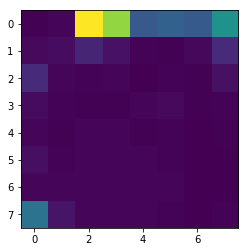

a


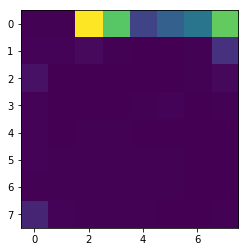

skateboard


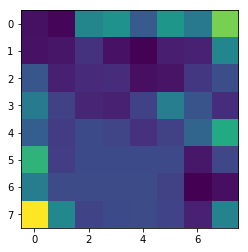

on


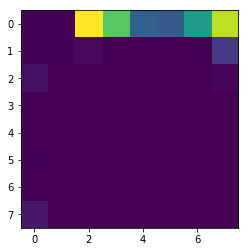

a


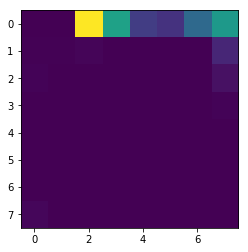

ramp


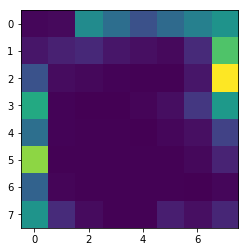

.


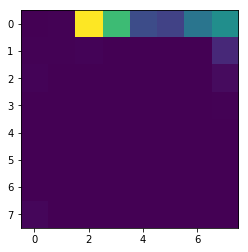

__EOS__


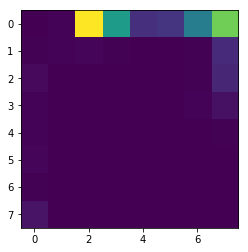

a man riding a skateboard on a ramp .


In [30]:
img = plt.imread('../hw4/data/skateboard.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.
plt.imshow(img)
plt.show()
print(' '.join(generate_caption(model, img, t=5., show_attn=True)[1:-1]))

In a positive example we see that attention firstly looks at the whole image, turns to the background, and then, on a word 'skateboard', looks at the whole image again. But mostly on every heat map attention has a tendency of looking at the center of an image for first two or three tokens and then drawing back to uninformative borders and the background. It means that further generation continues based mostly on information from previous tokens, not parts of an image.

Another positive example shows us how attention is drawing from a woman to a field as token generation continues.

/cephfs/home/tushin/kirill/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


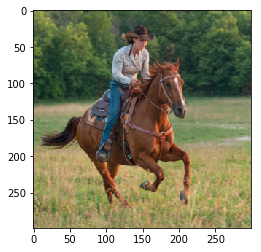

a


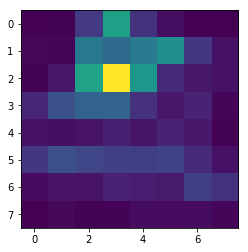

woman


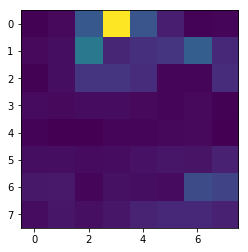

riding


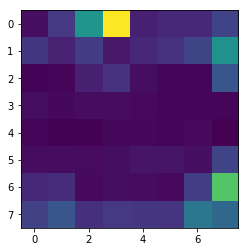

a


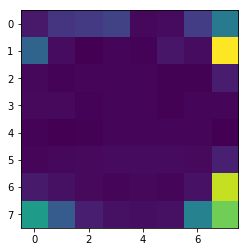

horse


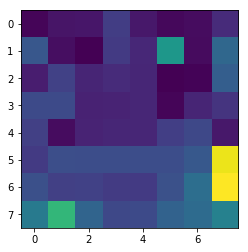

on


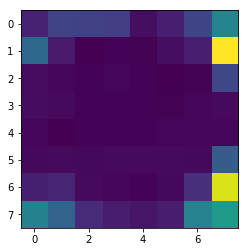

a


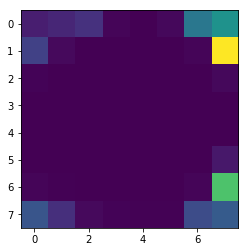

field


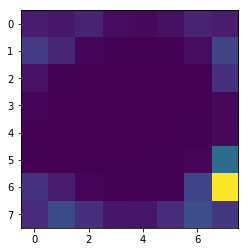

.


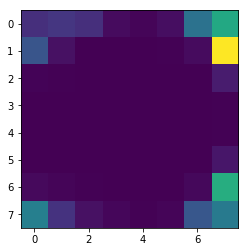

__EOS__


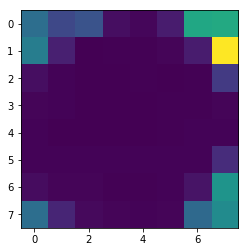

a woman riding a horse on a field .


In [99]:
img = plt.imread('../hw4/data/womanhorse.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.
plt.imshow(img)
plt.show()
print(' '.join(generate_caption(model, img, t=3., show_attn=True)[1:-1]))

Overall perfomance in cases with **self-made** photos turned out to be quite poor. I think that's because there were too many extra details on the image to look at and no focus on a certain subject, so attention layer didn't cope well with it.

### What else to try

If you're made it this far you're awesome and you should know it already. All the tasks below are completely optional and may take a lot of your time. Proceed at your own risk

#### Hard attention

* There are more ways to implement attention than simple softmax averaging. Here's [a lecture](https://www.youtube.com/watch?v=_XRBlhzb31U) on that. 
* We recommend you to start with [gumbel-softmax](https://blog.evjang.com/2016/11/tutorial-categorical-variational.html) or [sparsemax](https://arxiv.org/abs/1602.02068) attention.

#### Reinforcement learning

* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week7](https://github.com/yandexdataschool/Practical_RL/tree/spring19/week7_seq2seq)
* Theory: https://arxiv.org/abs/1612.00563

#### Chilling out

This is the final and the most advanced task in the DL course. And if you're doing this with the on-campus YSDA students, it should be late spring by now. There's got to be a better way to spend a few days than coding another deep learning model. If you have no idea what to do, ask Yandex. Or your significant other.

![img](https://imgs.xkcd.com/comics/computers_vs_humans.png)